## Introduction

In this notebook, I'll introduce a few different machine learning models and compare their performance. 

We will be dealing with:  
1. Linear Regression
2. K-Nearest Neighbors
3. Decision Tree
4. Random Forest
5. Neural Net

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score, confusion_matrix

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers

from statsmodels.api import OLS

import tensorflow as tf

import statsmodels.api as sm

%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [67]:
np.random.seed(10)

In [4]:
bikes = pd.read_csv('cleaned_bikes.csv', index_col=0)

First let's orient ourselves to the problem. We are trying to build a predictive model, which will tell us how many total rides per day will be taken with the bikeshare program. Here is how the number of bike rides looks when plotted along the time axis. 

In [5]:
bikes.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,total_rides,year,time_combined
0,2011-01-01,Winter,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011,2011-01-01 00:00:00
1,2011-01-01,Winter,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011,2011-01-01 01:00:00
2,2011-01-01,Winter,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011,2011-01-01 02:00:00
3,2011-01-01,Winter,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011,2011-01-01 03:00:00
4,2011-01-01,Winter,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011,2011-01-01 04:00:00


In [6]:
grouped = bikes.groupby('dteday').agg(['mean', 'sum'])
grouped.head()

hour      holiday     weekday      workingday       weather          temp           atemp               hum        windspeed             casual      registered       total_rides        year       
                 mean  sum    mean sum    mean  sum       mean sum      mean sum      mean   sum      mean     sum      mean    sum      mean     sum       mean  sum       mean   sum        mean   sum  mean    sum
dteday                                                                                                                                                                                                               
2011-01-01  11.500000  276       0   0       6  144          0   0  1.583333  38  0.344167  8.26  0.363625  8.7270  0.805833  19.34  0.160446  3.8507  13.791667  331  27.250000   654   41.041667   985  2011  48264
2011-01-02  11.782609  271       0   0       0    0          0   0  1.956522  45  0.363478  8.36  0.353739  8.1360  0.696087  16.01  0.248539  5.7164   5.695652  131  29.130435   670   34.826087   801  2011  46253
2011-01-03  12.318182  271       0   0       1   22          1  22  1.000000  22  0.196364  4.32  0.189405  4.1669  0.437273   9.62  0.248309  5.4628   5.454545  120  55.863636  1229   61.318182  1349  2011  44242
2011-01-04  11.869565  273       0   0       2   46          1  23  1.043478  24  0.200000  4.60  0.212122  4.8788  0.590435  13.58  0.160296  3.6868   4.695652  108  63.217391  1454   67.913043  1562  2011  46253
2011-01-05  11.869565  273       0   0       3   69          1  23  1.000000  23  0.226957  5.22  0.229270  5.2732  0.436957  10.05  0.186900  4.2987   3.565217   82  66.000000  1518   69.565217  1600  2011  46253

In [17]:
grouped.columns.levels[0]

Index(['hour', 'holiday', 'weekday', 'workingday', 'weather', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'total_rides', 'year'], dtype='object')

In [36]:
tot_rides = grouped.loc[:,('total_rides', 'sum')]

data = grouped.loc[:,(grouped.columns.levels[0], 'mean')]

In [37]:
data.columns = grouped.columns.levels[0]
data.head()

,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,total_rides,year
dteday,,,,,,,,,,,,,
2011-01-01,11.500000,0,6,0,1.583333,0.344167,0.363625,0.805833,0.160446,13.791667,27.250000,41.041667,2011
2011-01-02,11.782609,0,0,0,1.956522,0.363478,0.353739,0.696087,0.248539,5.695652,29.130435,34.826087,2011
2011-01-03,12.318182,0,1,1,1.000000,0.196364,0.189405,0.437273,0.248309,5.454545,55.863636,61.318182,2011
2011-01-04,11.869565,0,2,1,1.043478,0.200000,0.212122,0.590435,0.160296,4.695652,63.217391,67.913043,2011
2011-01-05,11.869565,0,3,1,1.000000,0.226957,0.229270,0.436957,0.186900,3.565217,66.000000,69.565217,2011


In [38]:
data.drop(['total_rides', 'year', 'hour', 'registered', 'casual'], axis=1, inplace=True)
data['total_rides'] = tot_rides

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
data.head()

,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,total_rides
dteday,,,,,,,,,
2011-01-01,0,6,0,1.583333,0.344167,0.363625,0.805833,0.160446,985
2011-01-02,0,0,0,1.956522,0.363478,0.353739,0.696087,0.248539,801
2011-01-03,0,1,1,1.000000,0.196364,0.189405,0.437273,0.248309,1349
2011-01-04,0,2,1,1.043478,0.200000,0.212122,0.590435,0.160296,1562
2011-01-05,0,3,1,1.000000,0.226957,0.229270,0.436957,0.186900,1600


In [40]:
data.index = pd.to_datetime(data.index)

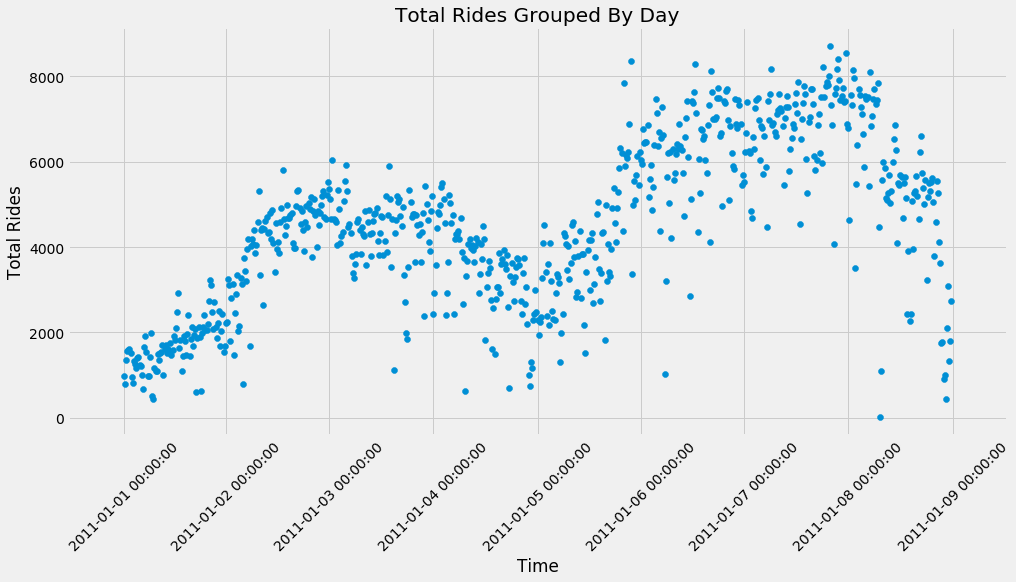

In [41]:
fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(data.index, data.total_rides)
ax.set_xlabel('Time')
ax.set_ylabel('Total Rides')
ax.set_title('Total Rides Grouped By Day')
ax.set_xticklabels(data.index, rotation=45);

In [44]:
xtrain, xtest, ytrain, ytest = train_test_split(data.drop('total_rides', axis=1), data.total_rides, random_state=10, test_size=0.2)
xtrain.head()

,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-06-22,0,3,1,1.416667,0.733333,0.693829,0.707500,0.172262
2011-05-23,0,1,1,1.666667,0.631667,0.590296,0.810000,0.233842
2011-08-26,0,5,1,1.250000,0.700000,0.659733,0.761250,0.083963
2012-06-15,0,5,1,1.000000,0.639167,0.599754,0.589583,0.176617
2012-05-02,0,3,1,1.416667,0.564167,0.537896,0.797083,0.138058


In [47]:
line = LinearRegression().fit(xtrain, ytrain)
line_preds = line.predict(xtest)
line_mse = mean_squared_error(ytest, line_preds)
print(f'Simple Linear MSE: {line_mse}')

Simple Linear MSE: 2196623.3127408135


In [48]:
ridge = RidgeCV(cv=5).fit(xtrain, ytrain)
ridge_preds = ridge.predict(xtest)
ridge_mse = mean_squared_error(ytest, ridge_preds)
print(f'Ridge Regression MSE: {ridge_mse}')

Ridge Regression MSE: 1999173.9017411957


In [49]:
lasso = LassoCV(cv=5).fit(xtrain, ytrain)
lasso_preds = lasso.predict(xtest)
lasso_mse = mean_squared_error(ytest, lasso_preds)
print(f'Lasso Regression MSE: {lasso_mse}')

Lasso Regression MSE: 2004335.5316461583


In [75]:
scaler = StandardScaler().fit(xtrain)
xtrain_scaled = scaler.transform(xtrain)
xtest_scaled = scaler.transform(xtest)
knn = KNeighborsRegressor(n_neighbors=20).fit(xtrain_scaled, ytrain)
knn_preds = knn.predict(xtest_scaled)
knn_mse = mean_squared_error(ytest, knn_preds)
print(f'KNN Regression MSE: {knn_mse}')

KNN Regression MSE: 1869528.2822619048


In [57]:
treeA = tree.DecisionTreeRegressor().fit(xtrain, ytrain)
tree_preds = treeA.predict(xtest)
tree_mse = mean_squared_error(ytest, tree_preds)
print(f'Simple Decision Tree MSE: {tree_mse}')

Simple Decision Tree MSE: 2688872.911564626


In [92]:
rf = RandomForestRegressor(n_estimators=50, random_state=10).fit(xtrain, ytrain)
rf_preds = rf.predict(xtest)
rf_mse = mean_squared_error(ytest, rf_preds)
print(f'Random Forest MSE: {rf_mse}')

Random Forest MSE: 1674599.8369741498


In [101]:
minmax = MinMaxScaler().fit(xtrain)
xtrain_mm = minmax.transform(xtrain)
xtest_mm = minmax.transform(xtest)

In [102]:
len(xtrain.columns)

8

In [133]:
# your code here
neural_net = keras.Sequential([
    keras.layers.Dense(8, input_shape=[8]),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

neural_net.compile(optimizer='adam',
                     loss='mse')

history = neural_net.fit(xtrain_mm, ytrain, epochs=1000, batch_size=80, validation_split=0.3, verbose=0)


In [134]:
nn_preds = neural_net.predict(xtest_mm)
nn_mse = mean_squared_error(ytest, nn_preds)
print(f'Neural Net MSE: {nn_mse}')

Neural Net MSE: 1991881.3473150714


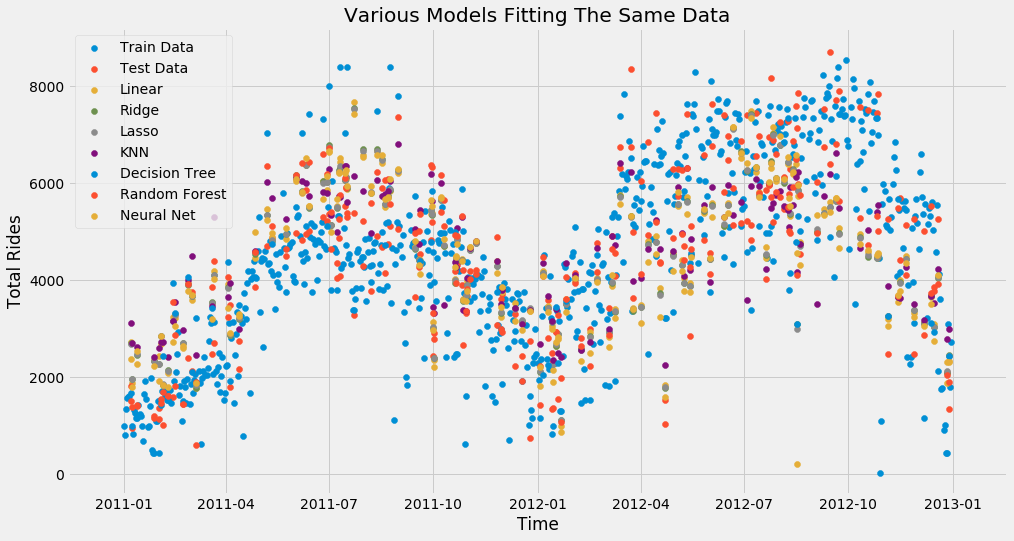

In [136]:
all_preds = [line_preds, ridge_preds, lasso_preds, knn_preds, tree_preds, rf_preds, nn_preds]
names = ['Linear', 'Ridge', 'Lasso', 'KNN', 'Decision Tree', 'Random Forest', 'Neural Net']
fig, ax = plt.subplots(figsize=(15,8))

ax.scatter(xtrain.index, ytrain, label='Train Data')
ax.scatter(xtest.index, ytest, label='Test Data')

for pred, name in zip(all_preds, names):
    ax.scatter(xtest.index, pred, label=name)

ax.set_title('Various Models Fitting The Same Data')
ax.set_xlabel('Time')
ax.set_ylabel('Total Rides')
ax.legend();

Here we see all of our models stacked up against one another. This is a bit of a messy plot, and I typically wouldn't include it in a report, but I think it does help to see that many of the models have similar fits *and* predictions. As we saw above, currently our random forest model performs the best on the test data, but only marginally so. 

________________

## What's next?

You're probably looking at those models and thinking, "eh". And you'd be right. These are the simplest baseline, expository models we could possible build (except for maybe the neural net). 

What we will going into next are some strategies and techniques to improve upon our models. 
1. Polynomial features
2. Interaction Terms
3. Pruning
4. Cross-Validation (we got a sneak peak with RidgeCV and LassoCV, so we will learn what the 'CV' part of those functions did)
5. Neural Net Regularizing (many different methods)